In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import resample
import scipy as sp
from matplotlib.colors import ListedColormap

pd.set_option("future.no_silent_downcasting", True)

In [91]:
import pandas as pd

df = pd.read_csv("./diabetic_data.csv")

cols_to_check = ["max_glu_serum", "A1Cresult"]

for col in cols_to_check:
    print(f"\nColumn: {col}")
    unique_vals = df[col].unique()
    print(f"Unique values ({len(unique_vals)}): {unique_vals}")
    # Also show which are missing
    missing_count = df[col].isna().sum()
    print(f"Number of missing (NaN) values: {missing_count}")



Column: max_glu_serum
Unique values (4): [nan '>300' 'Norm' '>200']
Number of missing (NaN) values: 96420

Column: A1Cresult
Unique values (4): [nan '>7' '>8' 'Norm']
Number of missing (NaN) values: 84748


In [263]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def preprocess_diabetic_data(file_path="./diabetic_data.csv"):
    # Load data
    df = pd.read_csv(file_path)
    df.replace("?", np.nan, inplace=True)
    
    # Remove invalid rows
    df = df[df.gender != "Unknown/Invalid"]
    df = df[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]
    
    # Drop irrelevant columns
    df.drop(columns=["encounter_id", "patient_nbr", "weight", "payer_code", "medical_specialty","examide", "citoglipton"], inplace=True)
    
    # --- Diagnosis grouping ---
    def icd_group(x):
        try:
            x = float(x)
        except:
            return 8
        if 390 <= x <= 459 or x == 785: return 0
        if 460 <= x <= 519 or x == 786: return 1
        if 520 <= x <= 579 or x == 787: return 2
        if x == 250: return 3
        if 800 <= x <= 999: return 4
        if 710 <= x <= 739: return 5
        if 580 <= x <= 629 or x == 788: return 6
        if 140 <= x <= 239: return 7
        return 8

    diag_cols = ["diag_1", "diag_2", "diag_3"]
    for col in diag_cols:
        df[col] = df[col].apply(icd_group).astype(np.int8)

    # --- Drugs encoding ---
    drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
             'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone',
             'metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

    for col in drugs:
        df[col] = df[col].replace(['No','Steady','Up','Down'], [0,1,1,1]).astype(int)

    # --- A1C and glucose ---
    df['A1Cresult'] = df['A1Cresult'].replace(['>7','>8','Norm','None'], [1,1,0,-99])
    df['A1Cresult'] = df['A1Cresult'].fillna(-99).astype(int)
    
    df['max_glu_serum'] = df['max_glu_serum'].replace(['>200','>300','Norm','None'], [1,1,0,-99])
    df['max_glu_serum'] = df['max_glu_serum'].fillna(-99).astype(int)

    # --- Map gender and diabetesMed/change ---
    df['gender'] = df['gender'].map({'Male':1,'Female':0}).astype(int)
    df['diabetesMed'] = df['diabetesMed'].map({'Yes':1,'No':0}).astype(int)
    df['change'] = df['change'].map({'Ch':1,'No':0}).astype(int)

    # --- Age numeric ---
    age_map = {"[0-10)":0,"[10-20)":1,"[20-30)":2,"[30-40)":3,"[40-50)":4,
               "[50-60)":5,"[60-70)":6,"[70-80)":7,"[80-90)":8,"[90-100)":9}
    df['age'] = df['age'].map(age_map).astype(int)

    # --- Fill missing race & one-hot ---
    df['race'].fillna(df['race'].mode()[0], inplace=True)

    # --- Group and one-hot encode IDs ---
    df['admission_type_id'] = df['admission_type_id'].replace({2:1, 7:1, 6:5, 8:5})
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace({
        6:1,8:1,9:1,13:1,
        3:2,4:2,5:2,14:2,22:2,23:2,24:2,
        12:10,15:10,16:10,17:10,
        25:18,26:18
    })
    df['admission_source_id'] = df['admission_source_id'].replace({
        2:1,3:1,
        5:4,6:4,10:4,22:4,25:4,
        15:9,17:9,20:9,21:9,
        13:11,14:11
    })

    # --- One-hot race + ID columns ---
    df = pd.get_dummies(df, columns=['race','admission_type_id','discharge_disposition_id','admission_source_id'])

    # --- Target ---
    df['readmitted'] = df['readmitted'].replace({'>30':1,'<30':1,'NO':0}).astype(int)

    # --- Train-test split ---
    X = df.drop(columns='readmitted')
    y = df['readmitted']

    # --- Encode diag columns numerically ---
    for col in diag_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

    return X,y


In [264]:
from sklearn.model_selection import train_test_split
import pandas as pd
from IPython.display import display, HTML

# Load and preprocess
X, y = preprocess_diabetic_data()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Combine X and y for display
df_train = X_train.copy()
df_train['readmitted'] = y_train

# Display first 50 rows as scrollable HTML
display(HTML(
    df_train.head(50).to_html(notebook=True)
    .replace('<table border="1" class="dataframe">', 
             '<div style="overflow-x:auto;"><table border="1" class="dataframe">') + '</div>'
))


C:\Users\ntnka\AppData\Local\Temp\ipykernel_3568\3952709897.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['race'].fillna(df['race'].mode()[0], inplace=True)


,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,admission_type_id_1,admission_type_id_3,admission_type_id_4,admission_type_id_5,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_7,discharge_disposition_id_10,discharge_disposition_id_18,discharge_disposition_id_27,discharge_disposition_id_28,admission_source_id_1,admission_source_id_4,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_11,readmitted
34395,0,7,1,35,1,8,3,0,0,8,0,3,6,-99,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,1
27163,1,7,6,74,0,24,0,0,0,1,0,1,9,-99,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,0
25781,0,3,2,22,3,15,0,0,1,8,8,8,8,-99,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,0
5002,0,8,10,45,2,22,0,0,0,0,0,7,9,-99,-99,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,0
72767,1,6,13,65,3,26,0,1,0,0,8,2,9,-99,-99,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,1
51750,0,4,1,41,0,6,0,0,0,1,8,0,3,-99,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,1
87022,0,3,1,10,1,8,0,0,0,7,8,6,6,-99,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,0
86931,1,5,1,53,0,18,0,2,4,1,1,8,9,-99,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,1
22148,1,5,6,58,4,42,0,0,1,0,8,8,9,-99,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,1
52401,1,7,6,31,1,18,0,0,1,8,8,8,9,-99,-99,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,1


In [212]:
df = pd.read_csv("./diabetic_data.csv")

# Count missing values per column
cols = ["number_diagnoses", "max_glu_serum", "A1Cresult"]
for col in cols:
    missing_count = (df[col] == "?" if df[col].dtype == object else df[col].isna()).sum()
    print(f"Column: {col}")
    print(f"Missing values: {missing_count}")
    print(f"Unique values sample: {df[col].dropna().unique()[:20]}")
    print("="*50)

Column: number_diagnoses
Missing values: 0
Unique values sample: [ 1  9  6  7  5  8  3  4  2 16 12 13 15 10 11 14]
Column: max_glu_serum
Missing values: 0
Unique values sample: ['>300' 'Norm' '>200']
Column: A1Cresult
Missing values: 0
Unique values sample: ['>7' '>8' 'Norm']


In [265]:
from sklearn.utils import resample

def balance_dataset_downsample(X, y):
    df_train = X.copy()
    df_train['target'] = y
    df_majority = df_train[df_train['target'] == 0]
    df_minority = df_train[df_train['target'] == 1]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority,
                                       replace=False,  # no replacement
                                       n_samples=len(df_minority),  # match minority
                                       random_state=42)
    
    # Combine minority with downsampled majority
    df_bal = pd.concat([df_majority_downsampled, df_minority])
    
    # Shuffle rows
    df_bal = df_bal.sample(frac=1, random_state=42).reset_index(drop=True)
    
    y_bal = df_bal['target']
    X_bal = df_bal.drop('target', axis=1)
    return X_bal, y_bal

X_train_bal, y_train_bal = balance_dataset_downsample(X_train, y_train)
y_train_bal.value_counts()


target
1    37453
0    37453
Name: count, dtype: int64

In [266]:
scaler = StandardScaler()
X_train_bal[num_cols] = scaler.fit_transform(X_train_bal[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

 and evaluating models...

--- Logistic Regression ---
Predict     0     1   All
Actual                   
0        1178   845  2023
1        1075   766  1841
All      2253  1611  3864
Accuracy: 0.63
Precision: 0.62
Recall: 0.55
F1-score: 0.58
ROC-AUC: 0.67

Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.70      0.66     10505
           1       0.62      0.55      0.58      9363

    accuracy                           0.63     19868
   macro avg       0.63      0.62      0.62     19868
weighted avg       0.63      0.63      0.62     19868


--- Decision Tree ---
Predict     0     1   All
Actual                   
0        1066   957  2023
1         983   858  1841
All      2049  1815  3864
Accuracy: 0.56
Precision: 0.54
Recall: 0.54
F1-score: 0.54
ROC-AUC: 0.58

Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.58      0.58     10505
           1       0.54      0

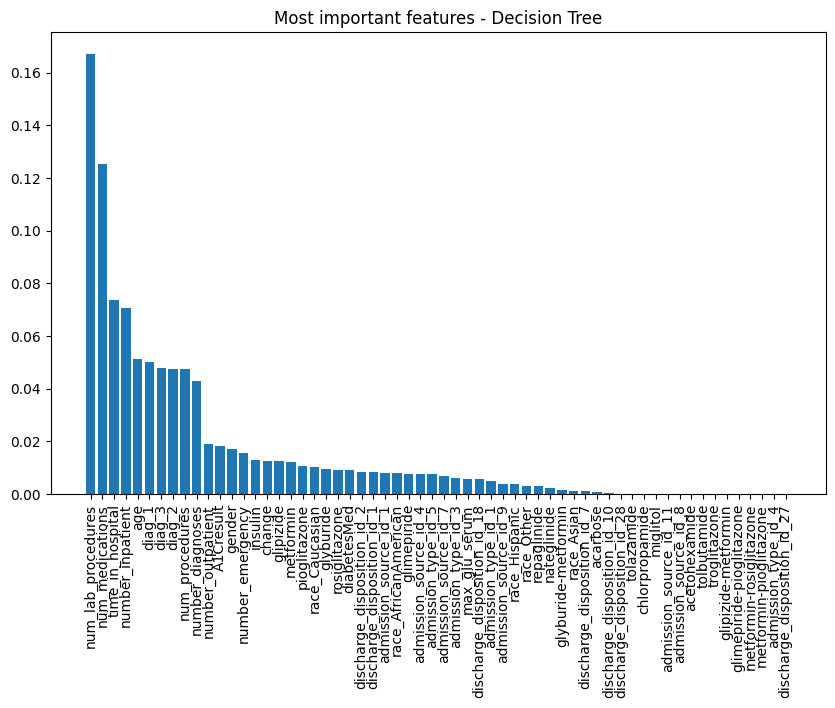


--- Random Forest ---
Predict     0     1   All
Actual                   
0        1057   966  2023
1         963   878  1841
All      2020  1844  3864
Accuracy: 0.64
Precision: 0.61
Recall: 0.61
F1-score: 0.61
ROC-AUC: 0.69

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.66      0.66     10505
           1       0.61      0.61      0.61      9363

    accuracy                           0.64     19868
   macro avg       0.63      0.63      0.63     19868
weighted avg       0.64      0.64      0.64     19868



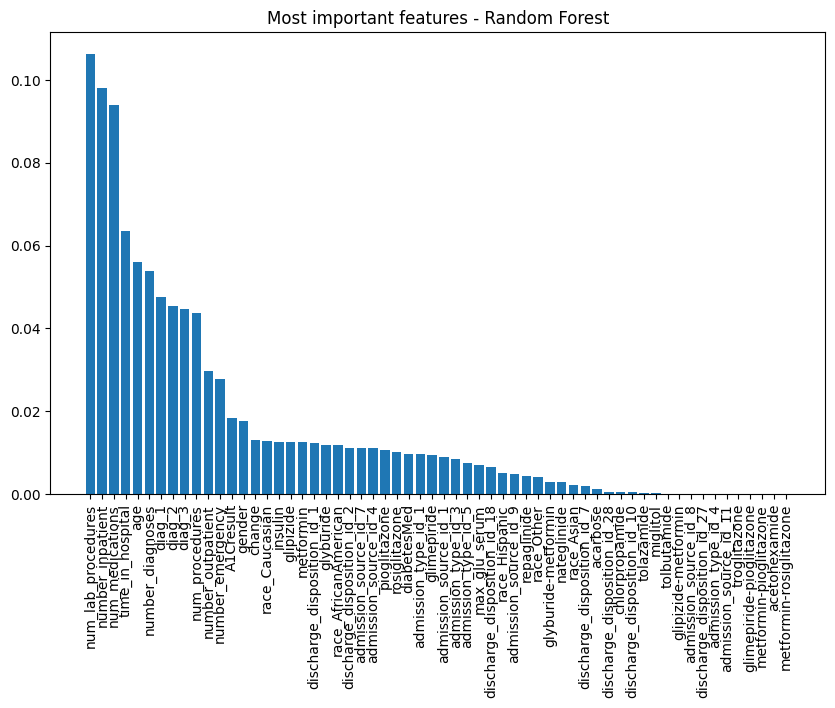


--- XGBoost ---


C:\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:48:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Predict     0     1   All
Actual                   
0        1056   967  2023
1         968   873  1841
All      2024  1840  3864
Accuracy: 0.64
Precision: 0.61
Recall: 0.61
F1-score: 0.61
ROC-AUC: 0.69

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.66      0.66     10505
           1       0.61      0.61      0.61      9363

    accuracy                           0.64     19868
   macro avg       0.64      0.64      0.64     19868
weighted avg       0.64      0.64      0.64     19868



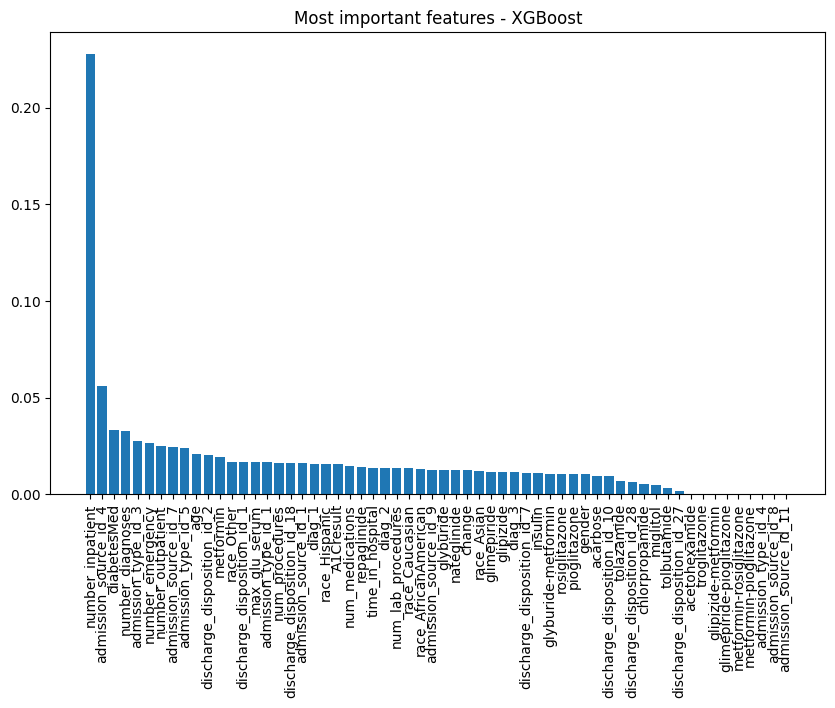

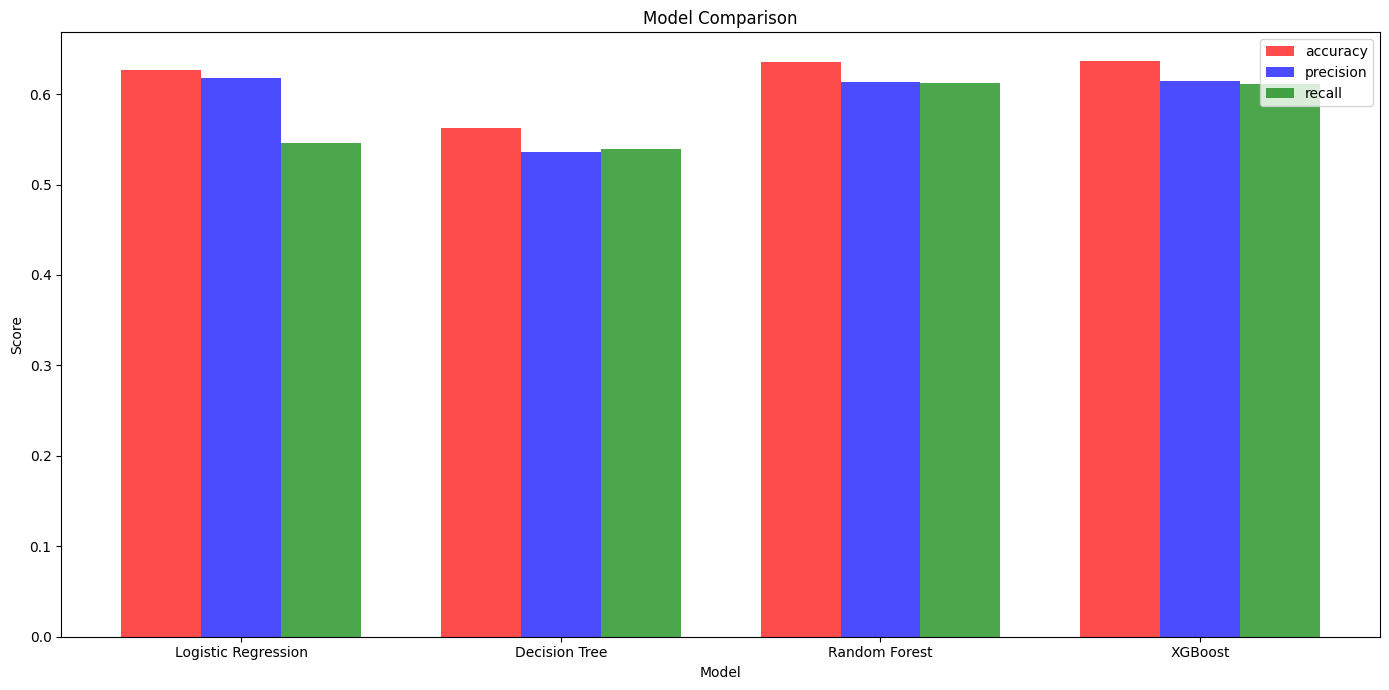

Analysis complete!


In [267]:
print(" and evaluating models...")

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

models = {
    "Logistic Regression": LogisticRegression(
        fit_intercept=True, penalty="l1", solver="liblinear", random_state=42,
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=28, criterion="entropy", min_samples_split=10, random_state=42,
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, max_depth=25, criterion="gini", min_samples_split=10,
        random_state=42
    ),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=(len(y_train_bal) - y_train_bal.sum()) / y_train_bal.sum(),  # balance classes
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    ),
}

results = {}
for name, model in models.items():
    # Use balanced training set
    result = train_and_evaluate_model(model, X_train_bal, X_test, y_train_bal, y_test, name)
    results[name] = result
    
    # Plot feature importance
    plot_feature_importance(
        result["model"], X_train_bal.columns, f"Most important features - {name}"
    )

# Plot comparison of all models
plot_model_comparison(results)

print("Analysis complete!")


In [220]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import pandas as pd

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"\n--- {model_name} ---")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # Confusion matrix
    cm = pd.crosstab(
        pd.Series(y_test, name="Actual"),
        pd.Series(y_pred, name="Predict"),
        margins=True,
    )
    print(cm)
    
    # Metrics (handle cases with 0 predictions)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # ROC-AUC (if model supports predict_proba)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    except AttributeError:
        roc_auc = None
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.2f}")
    
    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    return {
        "model": model,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm
    }


In [32]:
def plot_feature_importance(model, feature_names, title):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        importances = np.abs(model.coef_[0])

    most_imp_features = pd.DataFrame(
        {"Feature": feature_names, "Importance": importances}
    ).nlargest(10, "Importance")
    most_imp_features.sort_values(by="Importance", inplace=True)

    plt.figure(figsize=(10, 6))
    plt.barh(
        range(len(most_imp_features)),
        most_imp_features.Importance,
        align="center",
        alpha=0.8,
    )
    plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [33]:
def plot_model_comparison(results):
    plt.figure(figsize=(14, 7))
    x = np.arange(len(results))
    width = 0.25

    metrics = ["accuracy", "precision", "recall"]
    colors = ["red", "blue", "green"]

    for i, (metric, color) in enumerate(zip(metrics, colors)):
        values = [results[model_name][metric] for model_name in results.keys()]
        plt.bar(
            x + i * width, values, width=width, color=color, alpha=0.7, label=metric
        )

    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.title("Model Comparison")
    plt.xticks(x + width, results.keys())
    plt.legend()
    plt.tight_layout()
    plt.show()

In [217]:
print("Missing weight %:", df['weight'].isna().mean()*100)
print("Missing race %:", df['race'].isna().mean()*100)


Missing weight %: 0.0
Missing race %: 0.0


In [226]:
diag_cols = ['diag_1', 'diag_2', 'diag_3']

for col in diag_cols:
    print(col, "unique codes:", df[col].nunique())

# Simplify ICD codes: keep only first 3 digits (disease group)
for col in diag_cols:
    df[col] = df[col].astype(str).str[:3]


diag_1 unique codes: 717
diag_2 unique codes: 749
diag_3 unique codes: 790


readmitted
NO     0.539119
>30    0.349282
<30    0.111599
Name: proportion, dtype: float64


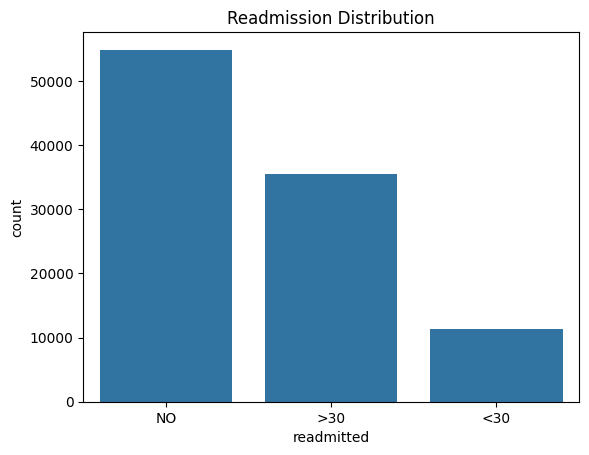

In [223]:
print(df['readmitted'].value_counts(normalize=True))

sns.countplot(x='readmitted', data=df)
plt.title("Readmission Distribution")
plt.show()


In [18]:
# Show first 10 unique codes in diag_1, diag_2, diag_3
print("Primary diagnoses:", df['diag_1'].dropna().unique()[:10])
print("Secondary diagnoses:", df['diag_2'].dropna().unique()[:10])
print("Tertiary diagnoses:", df['diag_3'].dropna().unique()[:10])

# Count unique codes
print("Unique diag_1 codes:", df['diag_1'].nunique())
print("Unique diag_2 codes:", df['diag_2'].nunique())
print("Unique diag_3 codes:", df['diag_3'].nunique())


Primary diagnoses: ['250' '276' '648' '8' '197' '414' '428' '398' '434' '157']
Secondary diagnoses: ['000' '250' '157' '411' '492' '427' '198' '403' '288' '998']
Tertiary diagnoses: ['000' '255' 'V27' '403' '250' 'V45' '38' '486' '996' '197']
Unique diag_1 codes: 684
Unique diag_2 codes: 673
Unique diag_3 codes: 697


Final shape: (101766, 49)


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,med_severity_score,med_pattern_variance
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,...,0,0,0,0,0,No,No,NO,0,0.000000
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,Missing,...,0,0,0,0,0,Ch,Yes,>30,3,0.625543
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,Missing,...,0,0,0,0,0,No,Yes,NO,1,0.208514
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,Missing,...,0,0,0,0,0,Ch,Yes,NO,3,0.625543
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,Missing,...,0,0,0,0,0,Ch,Yes,NO,2,0.288104


In [19]:
[col for col in med_columns if col not in df.columns]

[]

In [22]:
!pip install imbalanced-learn

   ---------------------------------------- 0.0/240.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/240.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/240.0 kB ? eta -:--:--
   --- ----------------------------------- 20.5/240.0 kB 165.2 kB/s eta 0:00:02
   ------ -------------------------------- 41.0/240.0 kB 245.8 kB/s eta 0:00:01
   ------------- ------------------------- 81.9/240.0 kB 416.7 kB/s eta 0:00:01
   ---------------------------------- --- 215.0/240.0 kB 875.2 kB/s eta 0:00:01
   -------------------------------------- 240.0/240.0 kB 866.9 kB/s eta 0:00:00


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
